In [184]:
import polars as pl
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import sys
work_path = Path(next((p for p in Path("__file__").resolve().parents if p.name == "Research"), None))
torchlib_path = str(work_path / Path("app/torch_libs"))
sys.path.append(torchlib_path)

from run_manager import RunManager, RunsManager, RunViewer


In [185]:
nb_path = Path().resolve()
# rm = RunManager(exp_path=nb_path)
# rm.ref_stats()
rv = RunViewer(exp_path=nb_path)
df_base = rv.fetch_results()

pass


In [186]:
df_res = df_base
df_res = df_res.filter(pl.col("run_id") < 150)

cols = ["classdist", "rand_str"]
# cols = ["train_dataset", "train_num", "classdist"]

df_uq = df_res.unique(cols, maintain_order=True).select(cols)

df_res_mf = None

for cond in df_uq.iter_rows(named=True):
    df_cond = df_res
    for k, v in cond.items():
        df_cond = df_cond.filter(pl.col(k) == v)
    
    max_fil = df_cond["fils"].max()
    # min_fil = df_cond["fils"].min()
    max_fil_vacc = df_cond.filter(pl.col("fils") == max_fil)["val_acc"].mean()
    
    df_cond = df_cond.with_columns(pl.lit(max_fil_vacc).alias("val_acc_mf"))
    
    if df_res_mf is None:
        df_res_mf = df_cond
    else:
        df_res_mf = pl.concat([df_res_mf, df_cond], how="vertical")
        


df_res_mf = df_res_mf.with_columns((pl.col("val_acc") - pl.col("val_acc_mf")).alias("mf_diff"))
# df_res_mf = df_res_mf.with_columns((pl.col("val_acc") / pl.col("val_acc_mf")).alias("mf_diff") - 1)
    
# df_res_mf = df_res_mf[:402]


with pl.Config() as cfg:
    cfg.set_tbl_rows(-1)
    cfg.set_tbl_cols(-1)
    display(df_res_mf)



ColumnNotFoundError: "rand_str" not found

array([[1.        , 0.67844212],
       [0.67844212, 1.        ]])

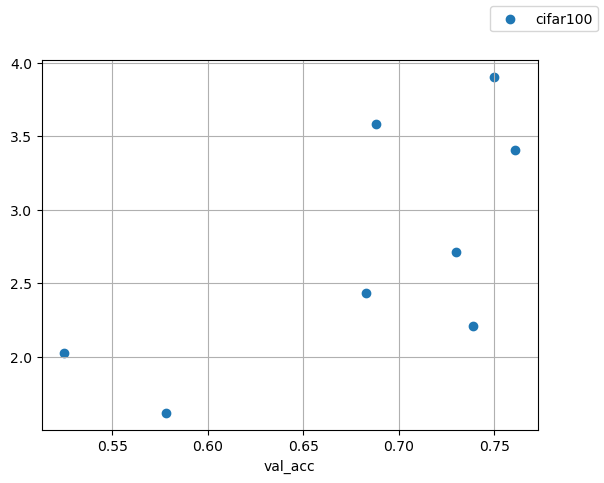

In [169]:
df_res_mf = df_res_mf.filter(pl.col("fils") == 1)

df_res_f1_b = df_res_mf

# df_res_mf = df_res_mf.filter(pl.col("train_num") == 1000)
df_res_mf = df_res_mf.sort("val_acc", descending=True)

df_res_f1 = df_res_f1_b.sort("val_acc", descending=True)

fig, ax = plt.subplots()

# ext_col = "train_num"
ext_col = "train_dataset"
x_col = "val_acc"
# x_col = "classdist"
# y_col = "mf_diff"
y_col = "classdist"

for ds in df_res_f1[ext_col].unique(maintain_order=True):
    df_res_ft = df_res_f1.filter(pl.col(ext_col) == ds)
    x = df_res_ft[x_col]
    y = df_res_ft[y_col]

    ax.scatter(x, y, label=ds[:-6])

ax.set_xlabel(x_col)
# ax.set_ylabel("val_acc (1fil) - val_acc (32fil)")
ax.grid()
fig.legend()
fig.show()

np.corrcoef(x, y)

